In [312]:
# Import Necessary Libraries

import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import multivariate_normal, bernoulli, beta, norm
from scipy.stats import ks_2samp
from scipy.special import expit as logistic_sigmoid
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.api import GLM, Poisson
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.metrics import brier_score_loss
from sklearn.model_selection import cross_val_score
from sklearn.metrics import balanced_accuracy_score, brier_score_loss, accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import KFold
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from statsmodels.discrete.discrete_model import NegativeBinomial
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error




# Set display option to avoid scientific notation in pandas, show up to 5 decimal points
pd.set_option('display.float_format', lambda x: '%.5f' % x)
# and numpy
np.set_printoptions(suppress=True, precision=5)
from kneed import KneeLocator

In [313]:
df =  pd.read_csv('final_data.csv')

In [314]:
df=df[df['year']>=2000]

In [315]:
print(df.columns.to_list())

['Unnamed: 0', 'att_Armed Assault', 'att_Assassination', 'att_Bombing/Explosion', 'att_Facility/Infrastructure Attack', 'att_Hijacking', 'att_Hostage Taking (Barricade Incident)', 'att_Hostage Taking (Kidnapping)', 'att_Unarmed Assault', 'weap_Biological', 'weap_Chemical', 'weap_Explosives', 'weap_Fake Weapons', 'weap_Firearms', 'weap_Incendiary', 'weap_Melee', 'weap_Other', 'weap_Radiological', 'weap_Sabotage Equipment', 'weap_Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)', 'targ_Abortion Related', 'targ_Airports & Aircraft', 'targ_Business', 'targ_Educational Institution', 'targ_Food or Water Supply', 'targ_Government (Diplomatic)', 'targ_Government (General)', 'targ_Journalists & Media', 'targ_Maritime', 'targ_Military', 'targ_NGO', 'targ_Other', 'targ_Police', 'targ_Private Citizens & Property', 'targ_Religious Figures/Institutions', 'targ_Telecommunication', 'targ_Terrorists/Non-State Militia', 'targ_Tourists', 'targ_Transportation', 'targ_Utilities',

In [316]:
df.drop(columns='Unnamed: 0',inplace=True)

In [317]:

df['letal'] = df['nkill'].apply(lambda x:1 if x !=0 else 0 )
df['weap_cbr'] = df['weap_Chemical'] + df['weap_Biological'] + df['weap_Radiological']
df['success_suicide'] = df['success'] * df['suicide']
df['compss'] = df['success'] * df['targ_Military']

In [318]:
#bins = 100
#df = df[df['nkill']>0]
df = df[df['nkill']<500]

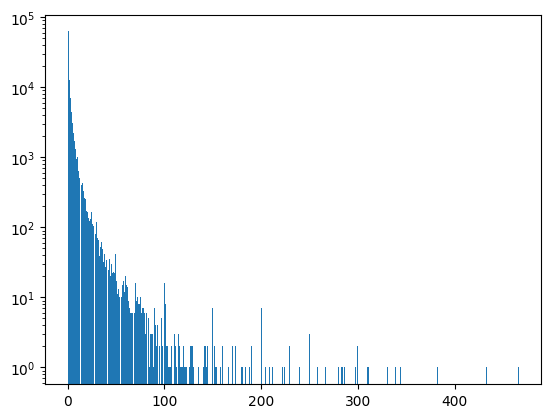

In [319]:
plt.hist(df['nkill'], bins=500)
plt.yscale('log')

In [320]:
positive_counts = df[df['nkill']>0]
positive_counts = positive_counts['nkill']

# Calculate mean and variance
mean_count = np.mean(positive_counts)
variance_count = np.var(positive_counts, ddof=1)  # ddof=1 for sample variance

print(f"Mean of positive counts: {mean_count}")
print(f"Variance of positive counts: {variance_count}")
# Print comparison
print("Comparison of mean and variance:")
print("Are the mean and variance approximately equal?", np.isclose(mean_count, variance_count, atol=10))

Mean of positive counts: 4.649277970725123
Variance of positive counts: 122.10251891818946
Comparison of mean and variance:
Are the mean and variance approximately equal? False


Elbow point at: 31


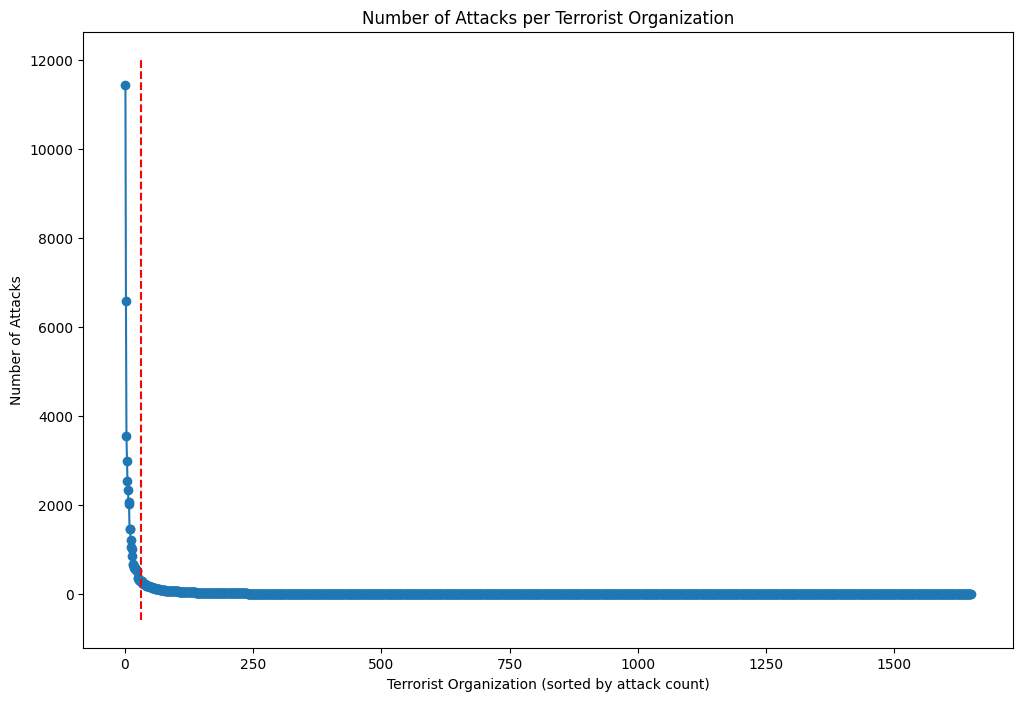

In [321]:
# Excluding 'Unknown'
df_filtered = df[df['gname'] != 'Unknown']

# Counting the number of attacks per organization
attacks_per_org = df_filtered['gname'].value_counts().sort_values(ascending=False)

# Converting to a format suitable for the Kneedle algorithm
# The Kneedle algorithm expects the data to be in a sorted order
x = range(1, len(attacks_per_org) + 1)
y = attacks_per_org.values

# Finding the elbow point
kneedle = KneeLocator(x, y, curve='convex', direction='decreasing')
elbow_point = kneedle.elbow

print(f"Elbow point at: {elbow_point}")

# Plotting
plt.figure(figsize=(12, 8))
plt.plot(x, y, marker='o', linestyle='-')
plt.vlines(elbow_point, plt.ylim()[0], plt.ylim()[1], linestyles='dashed',color = 'red')
plt.xlabel('Terrorist Organization (sorted by attack count)')
plt.ylabel('Number of Attacks')
plt.title('Number of Attacks per Terrorist Organization')

plt.show()

In [322]:
# identify the most common orgs
most_common_orgs = attacks_per_org.index.to_list()[:elbow_point]

# Modify the df['terrorist.org'] column
# Check if each value is in the most_common_orgs list, otherwise replace it with 'other'
df['gname'] = df['gname'].apply(lambda org: org if org in most_common_orgs else 'other')

In [323]:
new_drop = ['weap_Chemical','weap_Biological','weap_Radiological','v2x_ex_military','reg_South America','reg_Central Asia','targ_Telecommunication','weap_Sabotage Equipment']

to_dropp = ['weap_Firearms','country_txt','year','eventid','letal','motive','v2clsnlpct','att_Hijacking'] + new_drop

Reasons to drop the values

nperps has too many missing values makiing the len 31k, const value 0.6

In [324]:

X = df.drop(columns=to_dropp)


In [325]:
data_cleaned = X.dropna(axis=0, how='any')

In [326]:
print(data_cleaned.columns.to_list())

['att_Armed Assault', 'att_Assassination', 'att_Bombing/Explosion', 'att_Facility/Infrastructure Attack', 'att_Hostage Taking (Barricade Incident)', 'att_Hostage Taking (Kidnapping)', 'att_Unarmed Assault', 'weap_Explosives', 'weap_Fake Weapons', 'weap_Incendiary', 'weap_Melee', 'weap_Other', 'weap_Vehicle (not to include vehicle-borne explosives, i.e., car or truck bombs)', 'targ_Abortion Related', 'targ_Airports & Aircraft', 'targ_Business', 'targ_Educational Institution', 'targ_Food or Water Supply', 'targ_Government (Diplomatic)', 'targ_Government (General)', 'targ_Journalists & Media', 'targ_Maritime', 'targ_Military', 'targ_NGO', 'targ_Other', 'targ_Police', 'targ_Private Citizens & Property', 'targ_Religious Figures/Institutions', 'targ_Terrorists/Non-State Militia', 'targ_Tourists', 'targ_Transportation', 'targ_Utilities', 'targ_Violent Political Party', 'reg_Central America & Caribbean', 'reg_East Asia', 'reg_Eastern Europe', 'reg_Middle East & North Africa', 'reg_North Americ

In [327]:
len(data_cleaned)

133377

In [328]:
data_cleaned

,att_Armed Assault,att_Assassination,att_Bombing/Explosion,att_Facility/Infrastructure Attack,att_Hostage Taking (Barricade Incident),att_Hostage Taking (Kidnapping),att_Unarmed Assault,weap_Explosives,weap_Fake Weapons,weap_Incendiary,...,v2dlencmps,v2elembcap,v2exhoshog,Population,Net migration,Births from mothers aged 15 to 19 years,Population density,weap_cbr,success_suicide,compss
69833,1,0,0,0,0,0,0,0,0,0,...,0.85400,0.65000,1.00000,1819148.00000,5709.00000,8375.00000,2.20960,0,0,0
69834,0,0,0,0,0,1,0,0,0,0,...,0.85400,0.65000,1.00000,1819148.00000,5709.00000,8375.00000,2.20960,0,0,0
69835,1,0,0,0,0,0,0,0,0,0,...,1.22200,1.49900,0.00000,1059633660.00000,-149966.00000,5222965.00000,356.39620,0,0,0
69836,0,0,1,0,0,0,0,1,0,0,...,1.24300,0.77200,1.00000,1823291.00000,-9176.00000,2092.00000,167.19730,0,0,0
69837,1,0,0,0,0,0,0,0,0,0,...,-2.88900,-2.32100,0.00000,8721465.00000,53580.00000,58967.00000,13.90230,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209699,0,0,1,0,0,0,0,1,0,0,...,-1.79300,-0.70400,0.00000,32284044.00000,-86100.00000,95767.00000,61.14750,0,0,0
209700,0,0,0,1,0,0,0,0,0,1,...,1.23400,0.87100,0.00000,29348626.00000,306664.00000,103669.00000,199.40500,0,0,0
209703,0,0,0,1,0,0,0,0,0,1,...,2.16200,2.66900,0.00000,83328990.00000,334055.00000,13881.00000,239.06640,0,0,1
209704,1,0,0,0,0,0,0,0,0,0,...,0.20400,-0.09100,1.00000,38972236.00000,166821.00000,188016.00000,60.02230,0,0,0


In [329]:
y_cleaned = data_cleaned['nkill']
y_log_cleaned = np.log(data_cleaned['nkill'])
X_cleaned = data_cleaned.drop(columns=['nkill'])

c:\Users\lucab\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [330]:
X_encoded = pd.get_dummies(X_cleaned, columns=['gname'], drop_first=True).astype(int)

no filters:
['gname_Maoists','targ_NGO','INT_MISC','individual','v2exhoshog','gname_Farabundo Marti National Liberation Front (FMLN)']

with filter:
['gname_Narco-Terrorists','gname_Maoists','targ_NGO','INT_MISC','individual','targ_Abortion Related','gname_Protestant extremists']

In [331]:
X_encoded = X_encoded.drop(columns=['targ_NGO','INT_MISC','individual','targ_Abortion Related'])

removing by coefficient

In [332]:
#X_encoded = X_encoded.drop(columns=

#'gname_Death Squad','gname_Mozambique National Resistance Movement (MNR)',"gname_People's Liberation Front (JVP)",'gname_Corsican National Liberation Front (FLNC)','gname_Hezbollah','gname_National Union for the Total Independence of Angola (UNITA)','gname_Protestant extremists',
#X_encoded = X_encoded.drop(columns=['weap_Fake Weapons', 'reg_Central America & Caribbean', 'multiple', 'v2exhoshog', 'gname_Revolutionary Armed Forces of Colombia (FARC)'])
X_encoded = X_encoded.drop(columns=['reg_Southeast Asia','weap_Incendiary', 'v2dlencmps', 'gname_Communist Party of India - Maoist (CPI-Maoist)', "gname_Donetsk People's Republic", 'gname_Hamas (Islamic Resistance Movement)', 'gname_Maoists', 'gname_Revolutionary Armed Forces of Colombia (FARC)', 'gname_United Liberation Front of Assam (ULFA)','weap_Melee','weap_Other','reg_Central America & Caribbean','v2exhoshog','v2elembcap','v2clacfree','targ_Educational Institution'])
#X_encoded = X_encoded.drop(columns=['att_Hostage Taking (Barricade Incident)', 'att_Hostage Taking (Kidnapping)', 'weap_Fake Weapons', 'weap_Incendiary', 'weap_Melee', 'weap_Other', 'targ_Food or Water Supply', 'targ_Government (Diplomatic)', 'targ_Journalists & Media', 'targ_Maritime', 'targ_Other', 'targ_Tourists', 'targ_Utilities', 'reg_Central America & Caribbean', 'reg_Eastern Europe', 'reg_Southeast Asia', 'multiple', 'v2clacfree', 'v2dlencmps', 'v2elembcap', 'v2exhoshog', 'weap_cbr', 'gname_Al-Qaida in Iraq', 'gname_Al-Qaida in the Arabian Peninsula (AQAP)', 'gname_Algerian Islamic Extremists', 'gname_Allied Democratic Forces (ADF)', 'gname_Baloch Republican Army (BRA)', 'gname_Bangsamoro Islamic Freedom Movement (BIFM)', 'gname_Boko Haram', 'gname_Communist Party of India - Maoist (CPI-Maoist)', "gname_Donetsk People's Republic", 'gname_Fulani extremists', 'gname_Hamas (Islamic Resistance Movement)', 'gname_Khorasan Chapter of the Islamic State', 'gname_Liberation Tigers of Tamil Eelam (LTTE)', "gname_Lord's Resistance Army (LRA)", 'gname_Maoists', 'gname_Moro Islamic Liberation Front (MILF)', 'gname_Muslim extremists', 'gname_Revolutionary Armed Forces of Colombia (FARC)', 'gname_Sinai Province of the Islamic State', 'gname_Tehrik-i-Taliban Pakistan (TTP)', 'gname_Tripoli Province of the Islamic State', 'gname_United Liberation Front of Assam (ULFA)'])
#X_encoded = X_encoded.drop(columns=['att_Armed Assault', 'att_Hostage Taking (Barricade Incident)', 'att_Hostage Taking (Kidnapping)', 'weap_Fake Weapons', 'weap_Incendiary', 'weap_Melee', 'weap_Other', 'targ_Airports & Aircraft', 'targ_Educational Institution', 'targ_Food or Water Supply', 'targ_Government (Diplomatic)', 'targ_Journalists & Media', 'targ_Maritime', 'targ_Other', 'targ_Tourists', 'targ_Utilities', 'targ_Violent Political Party', 'reg_Central America & Caribbean', 'reg_East Asia', 'reg_Eastern Europe', 'reg_North America', 'reg_Southeast Asia', 'reg_Western Europe', 'multiple', 'v2clacfree', 'v2dlencmps', 'v2elembcap', 'v2exhoshog', 'weap_cbr', 'gname_Al-Qaida in Iraq', 'gname_Al-Qaida in the Arabian Peninsula (AQAP)', 'gname_Al-Shabaab', 'gname_Algerian Islamic Extremists', 'gname_Allied Democratic Forces (ADF)', 'gname_Baloch Republican Army (BRA)', 'gname_Bangsamoro Islamic Freedom Movement (BIFM)', 'gname_Boko Haram', 'gname_Communist Party of India - Maoist (CPI-Maoist)', "gname_Donetsk People's Republic", 'gname_Fulani extremists', 'gname_Hamas (Islamic Resistance Movement)', 'gname_Houthi extremists (Ansar Allah)', 'gname_Islamic State of Iraq and the Levant (ISIL)', 'gname_Khorasan Chapter of the Islamic State', "gname_Kurdistan Workers' Party (PKK)", 'gname_Liberation Tigers of Tamil Eelam (LTTE)', "gname_Lord's Resistance Army (LRA)", 'gname_Maoists', 'gname_Moro Islamic Liberation Front (MILF)', 'gname_Muslim extremists', 'gname_National Liberation Army of Colombia (ELN)', "gname_New People's Army (NPA)", 'gname_Palestinian Extremists', 'gname_Revolutionary Armed Forces of Colombia (FARC)', 'gname_Separatists', 'gname_Sinai Province of the Islamic State', 'gname_Taliban', 'gname_Tehrik-i-Taliban Pakistan (TTP)', 'gname_Tripoli Province of the Islamic State', 'gname_United Liberation Front of Assam (ULFA)'])
#X_encoded = X_encoded.drop(columns=['att_Hostage Taking (Barricade Incident)', 'att_Hostage Taking (Kidnapping)', 'weap_Fake Weapons', 'weap_Incendiary', 'weap_Melee', 'weap_Other', 'targ_Food or Water Supply', 'targ_Government (Diplomatic)', 'targ_Journalists & Media', 'targ_Maritime', 'targ_Other', 'targ_Tourists', 'targ_Utilities', 'reg_Central America & Caribbean', 'reg_Eastern Europe', 'reg_Southeast Asia', 'multiple', 'v2clacfree', 'v2dlencmps', 'v2elembcap', 'v2exhoshog', 'weap_cbr', 'gname_Al-Qaida in Iraq', 'gname_Al-Qaida in the Arabian Peninsula (AQAP)', 'gname_Algerian Islamic Extremists', 'gname_Allied Democratic Forces (ADF)', 'gname_Baloch Republican Army (BRA)', 'gname_Bangsamoro Islamic Freedom Movement (BIFM)', 'gname_Boko Haram', 'gname_Communist Party of India - Maoist (CPI-Maoist)', "gname_Donetsk People's Republic", 'gname_Fulani extremists', 'gname_Hamas (Islamic Resistance Movement)', 'gname_Khorasan Chapter of the Islamic State', 'gname_Liberation Tigers of Tamil Eelam (LTTE)', "gname_Lord's Resistance Army (LRA)", 'gname_Maoists', 'gname_Moro Islamic Liberation Front (MILF)', 'gname_Muslim extremists', 'gname_Revolutionary Armed Forces of Colombia (FARC)', 'gname_Sinai Province of the Islamic State', 'gname_Tehrik-i-Taliban Pakistan (TTP)', 'gname_Tripoli Province of the Islamic State', 'gname_United Liberation Front of Assam (ULFA)'])
#X_encoded = X_encoded.drop(columns=['att_Hostage Taking (Kidnapping)', 'weap_Fake Weapons', 'targ_Government (Diplomatic)', 'targ_Other', 'reg_Eastern Europe', 'multiple', 'gname_Boko Haram', 'gname_Houthi extremists (Ansar Allah)', "gname_People's Liberation Front (JVP)","reg_Central America & Caribbean"])
#X_encoded = X_encoded.drop(columns=['att_Armed Assault', 'att_Hostage Taking (Barricade Incident)', 'weap_Melee', 'weap_Other', 'targ_Educational Institution', 'targ_Food or Water Supply', 'targ_Government (Diplomatic)', 'targ_Maritime', 'targ_Other', 'targ_Tourists', 'reg_Eastern Europe', 'reg_Southeast Asia', 'multiple', 'v2exhoshog', 'weap_cbr', 'gname_Al-Qaida in Iraq', 'gname_Al-Qaida in the Arabian Peninsula (AQAP)', 'gname_Basque Fatherland and Freedom (ETA)', 'gname_Boko Haram', 'gname_Communist Party of India - Maoist (CPI-Maoist)', "gname_Donetsk People's Republic", 'gname_Farabundo Marti National Liberation Front (FMLN)', 'gname_Fulani extremists', 'gname_Houthi extremists (Ansar Allah)', 'gname_Irish Republican Army (IRA)', 'gname_Khorasan Chapter of the Islamic State', "gname_Kurdistan Workers' Party (PKK)", 'gname_Maoists', 'gname_Muslim extremists', 'gname_National Liberation Army of Colombia (ELN)', "gname_New People's Army (NPA)", 'gname_Nicaraguan Democratic Force (FDN)', 'gname_Revolutionary Armed Forces of Colombia (FARC)', 'gname_Separatists', 'gname_Sikh Extremists', 'gname_Sinai Province of the Islamic State', 'gname_Tehrik-i-Taliban Pakistan (TTP)'])
#X_encoded = X_encoded.drop(columns=['targ_Food or Water Supply', 'reg_Southeast Asia', 'v2exhoshog', 'gname_Communist Party of India - Maoist (CPI-Maoist)', "gname_Donetsk People's Republic", 'gname_Farabundo Marti National Liberation Front (FMLN)', 'gname_Irish Republican Army (IRA)', 'gname_Maoists', 'gname_Sinai Province of the Islamic State'])

In [333]:
# Drop variables with 0 variability (no information) or high correlation (multicollinearity)

# VarianceThreshold with a threshold of 0 (default) to remove 0 variance columns
selector = VarianceThreshold()
X_encoded_var_filtered = selector.fit_transform(X_encoded)
# Get the columns after variance thresholding
X_encoded_var_filtered = X_encoded.iloc[:, selector.get_support(indices=True)]

In [334]:
# Calculate the correlation matrix (absolute value - we don't care about direction of correlation)
corr_matrix = X_encoded_var_filtered.corr().abs()

# Select upper triangle of correlation matrix
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Initialize an empty list to keep track of columns to drop
to_drop = []

# Iterate over the columns of the upper triangle
for column in upper_tri.columns:
    for row in upper_tri.index:
        # Check if the correlation is above the threshold and the column hasn't been considered yet
        if upper_tri.loc[row, column] > 0.9 and column not in to_drop and row not in to_drop:
            to_drop.append(column)
            break  # Break the loop once a column is marked for dropping

# 'to_drop' contains columns where only one of each highly correlated pair is considered for dropping

In [335]:
print(to_drop)

['weap_Explosives', 'success_suicide', 'compss']


In [336]:
X_encoded_final = X_encoded_var_filtered.drop(columns=to_drop)

In [337]:
# Standardise features to help with interpretation 

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit on training set only
scaler.fit(X_encoded_final)

# Apply transform to both the training set and the test set
X_train_scaled = pd.DataFrame(scaler.transform(X_encoded_final), columns=X_encoded_final.columns, index=X_encoded_final.index)

In [338]:
X_encoded_with_const = sm.add_constant(X_train_scaled)

In [339]:
#model_nb = NegativeBinomial(y_cleaned, X_encoded_with_const.drop(columns=['weap_Melee','weap_Other','reg_Central America & Caribbean','v2exhoshog','v2elembcap','v2clacfree','targ_Educational Institution'])).fit(maxiter=1000)
model_nb = NegativeBinomial(y_cleaned, X_encoded_with_const).fit(maxiter=1000)

print(model_nb.summary())

Optimization terminated successfully.
         Current function value: 1.696610
         Iterations: 37
         Function evaluations: 41
         Gradient evaluations: 41
                     NegativeBinomial Regression Results                      
Dep. Variable:                  nkill   No. Observations:               133377
Model:               NegativeBinomial   Df Residuals:                   133309
Method:                           MLE   Df Model:                           67
Date:                Mon, 22 Apr 2024   Pseudo R-squ.:                  0.1031
Time:                        11:27:00   Log-Likelihood:            -2.2629e+05
converged:                       True   LL-Null:                   -2.5230e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                                                       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------

In [340]:
X_encoded_with_const.to_csv('big_X.csv')

In [341]:
y_cleaned.to_csv('big_y.csv')

In [342]:
X = X_encoded_with_const  
y = y_cleaned


In [343]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)  # 5-fold cross-validation


In [344]:
rmse_scores = []
for train_index, test_index in kf.split(X):
    # Split the data into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Fit the Negative Binomial model on the training data
    nb_model = NegativeBinomial(y_train, X_train)
    nb_results = nb_model.fit(disp=0,maxiter=100)  # Set disp=0 to turn off verbose output
    
    # Predict on the testing set
    y_pred = nb_results.predict(X_test)
    
    # Calculate the root mean squared error and store
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_scores.append(rmse)

# Calculate average RMSE over all folds
average_rmse = np.mean(rmse_scores)
print(f'Average RMSE across all folds: {average_rmse}')


Average RMSE across all folds: 8.130602385874607


In [345]:
intercept = 0.3020
coef_military = 0.4509
coef_armed_assault = -0.0920
coef_suicide = 0.3819

# Calculate the log-expected count (log scale prediction)
log_lambda = intercept + coef_military + coef_armed_assault + coef_suicide

# Convert log scale prediction to the original count scale (expected number of kills)
expected_kills = np.exp(log_lambda)

print(f"Expected number of fatalities in a terrorist attack targeting the military with an armed assault and a suicide attack: {expected_kills:.2f}")
from scipy.stats import nbinom

# Number of deaths for which to calculate the probability
deaths = 1

# The parameters of the Negative Binomial distribution
r = np.exp(intercept)  # or other baseline count depending on the model setup
p = 1 / (1 + expected_kills)

# Calculate the probability of exactly 'deaths' deaths
probability = nbinom.pmf(deaths, r, p)
print(f"Probability of exactly {deaths} deaths: {probability:.4f}")


Expected number of fatalities in a terrorist attack targeting the military with an armed assault and a suicide attack: 2.84
Probability of exactly 1 deaths: 0.1622


In [346]:
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:90% !important; }</style>"))

# Fitting the linear regression model
model = sm.GLM(y_cleaned, X_encoded_with_const, family=sm.families.Poisson()).fit()

# Displaying the regression results
print(model.summary())

C:\Users\lucab\AppData\Local\Temp\ipykernel_31628\453724424.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


                 Generalized Linear Model Regression Results                  
Dep. Variable:                  nkill   No. Observations:               133377
Model:                            GLM   Df Residuals:                   133309
Model Family:                 Poisson   Df Model:                           67
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -4.3380e+05
Date:                Mon, 22 Apr 2024   Deviance:                   6.6852e+05
Time:                        11:27:34   Pearson chi2:                 2.08e+06
No. Iterations:                     8   Pseudo R-squ. (CS):             0.9074
Covariance Type:            nonrobust                                         
                                                                                       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------

In [347]:


# Define the intercept and coefficients for the relevant predictors
intercept = 0.3560
coef_military = 0.4434  # Coefficient for targeting the military
coef_armed_assault = -0.0714  # Coefficient for armed assault
suis = 0.3446

# Calculate the log-expected count (log scale prediction)
log_lambda = intercept + coef_military + coef_armed_assault + suis

# Convert log scale prediction to the original count scale (expected number of kills)
expected_kills = np.exp(log_lambda)

print(f"Expected number of fatalities in a terrorist attack targeting the military with an armed assault: {expected_kills:.2f}")


Expected number of fatalities in a terrorist attack targeting the military with an armed assault: 2.92


In [348]:
# extract and plot regression coefficients 
beta_mean = model_nb.params
beta_cov = model_nb.cov_params()

# Number of simulations
n_simulations = 1000

# Simulate beta coefficients
simulated_betas = multivariate_normal.rvs(mean=beta_mean, cov=beta_cov, size=n_simulations)
#simulated_betas = multivariate_normal.rvs(mean=beta_mean[:-1], cov=beta_cov[:-1,:-1], size=n_simulations)

simulations_df = pd.DataFrame(model.params)
long_df = simulations_df.melt(var_name='Coefficient', value_name='Value')

In [349]:
tresholdd=0.01

In [350]:
mask=simulations_df<tresholdd
ggg=simulations_df[mask]
mask2 = ggg>-tresholdd
gg44=ggg[mask2]
lista = gg44.dropna()
print(lista.index.to_list())

[]


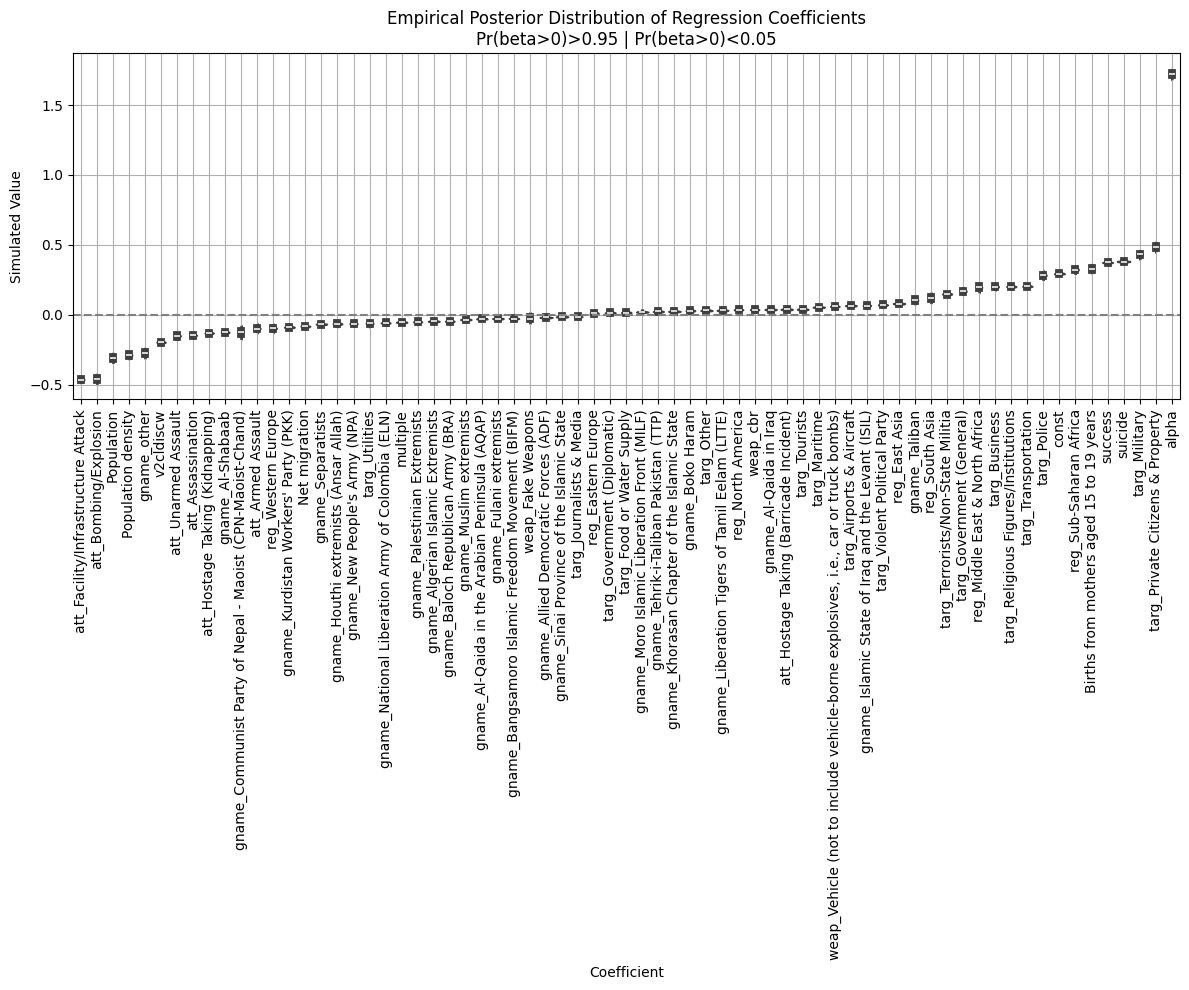

In [351]:
# Transform simulated_betas into a DataFrame for plotting
simulations_df = pd.DataFrame(simulated_betas, columns=model_nb.params.index)

# Convert the DataFrame from wide to long format
long_df = simulations_df.melt(var_name='Coefficient', value_name='Value')

# Calculate the probability of coef > 0 for each coefficient
prob_greater_than_zero = long_df.groupby('Coefficient')['Value'].apply(lambda x: np.mean(x > 0)).reset_index()
prob_greater_than_zero.rename(columns={'Value': 'P(coef>0)'}, inplace=True)

# Filter coefficients based on the probability criterion
filtered_coefs = prob_greater_than_zero[
    (prob_greater_than_zero['P(coef>0)'] > 0.95) | (prob_greater_than_zero['P(coef>0)'] < 0.05)
]['Coefficient']

# Filter the long_df to include only the selected coefficients
filtered_long_df = long_df[long_df['Coefficient'].isin(filtered_coefs)]

# Calculate the median of the simulated values for each filtered coefficient
medians = filtered_long_df.groupby('Coefficient')['Value'].median().reset_index()

# Sort the filtered medians
medians_sorted = medians.sort_values(by='Value')


# Plotting the filtered and ordered coefficients
plt.figure(figsize=(12, 10))  # Adjust the figure size as needed
sns.violinplot(x='Coefficient', y='Value', data=filtered_long_df, order=medians_sorted['Coefficient'])

# Add a vertical dotted line at x = 0
plt.axhline(y=0, color='grey', linestyle='--')

# Additional customization
plt.title('Empirical Posterior Distribution of Regression Coefficients\nPr(beta>0)>0.95 | Pr(beta>0)<0.05')
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
plt.xlabel('Coefficient')
plt.ylabel('Simulated Value')
plt.grid(True)

# Display the plot
plt.tight_layout()  # Adjust layout to not cut off labels
plt.show()

In [352]:
fff=X_encoded_with_const

In [353]:
fff.shape[0]

133377

In [354]:

predicted_counts = np.zeros((n_simulations, fff.shape[0]))


In [355]:
""""import numpy as np
import pandas as pd
from scipy.stats import nbinom

# Assuming `fff` is your feature matrix and `n_simulations` is defined
# Example data for `simulated_betas` and `dispersion_parameter_r`
simulated_betas = [np.random.normal(size=fff.shape[1]) for _ in range(n_simulations)]  # example beta coefficients
dispersion_parameter_r = 1.5  # This should ideally come from your model

# Generate predictions for each simulation
for i in range(n_simulations):
    beta_simulation = simulated_betas[i]
    predicted_rate = np.exp(np.dot(fff, beta_simulation))  # Mean number of events (lambda)
    
    # For Negative Binomial, we need to calculate `p` (success probability)
    # Using the parameterization p = r / (r + mean) where mean is `predicted_rate`
    p = dispersion_parameter_r / (dispersion_parameter_r + predicted_rate)
    
    # Generate random outcomes from a negative binomial distribution
    predicted_counts[i] = nbinom.rvs(dispersion_parameter_r, p)

print(predicted_counts)
"""

'"import numpy as np\nimport pandas as pd\nfrom scipy.stats import nbinom\n\n# Assuming `fff` is your feature matrix and `n_simulations` is defined\n# Example data for `simulated_betas` and `dispersion_parameter_r`\nsimulated_betas = [np.random.normal(size=fff.shape[1]) for _ in range(n_simulations)]  # example beta coefficients\ndispersion_parameter_r = 1.5  # This should ideally come from your model\n\n# Generate predictions for each simulation\nfor i in range(n_simulations):\n    beta_simulation = simulated_betas[i]\n    predicted_rate = np.exp(np.dot(fff, beta_simulation))  # Mean number of events (lambda)\n    \n    # For Negative Binomial, we need to calculate `p` (success probability)\n    # Using the parameterization p = r / (r + mean) where mean is `predicted_rate`\n    p = dispersion_parameter_r / (dispersion_parameter_r + predicted_rate)\n    \n    # Generate random outcomes from a negative binomial distribution\n    predicted_counts[i] = nbinom.rvs(dispersion_parameter_r, p

In [356]:
from scipy.stats import nbinom
from sklearn.metrics import mean_squared_error
r=1.7

# Let's assume `r` is the dispersion parameter and `p` is the success probability
# for the Negative Binomial distribution that you've estimated from your model.
# Also, let `simulated_betas` be the array of simulated coefficients.

# We'll also need `fff` which should be your feature matrix.
# And 'y_cleaned' should be your cleaned observed values for comparison.

# Generate predicted counts using the NB model
predicted_counts = []
for beta_simulation in simulated_betas:
    mean_predicted_rate = np.exp(np.dot(fff, beta_simulation[:-1]))  # log-linear model prediction     must consider without the aplha value
    p = 1 / (1 + mean_predicted_rate * r)  # convert mean rate to probability for NB
    predicted_counts.append(nbinom.rvs(r, p))  # simulate from NB

predicted_counts = np.array(predicted_counts)
monte_carlo_medians = np.median(predicted_counts, axis=0)
prediction_intervals = np.percentile(predicted_counts, [2.5, 97.5], axis=0)

# Calculate metrics
correlation = np.corrcoef(monte_carlo_medians, y_cleaned)[0, 1]
rmse = np.sqrt(mean_squared_error(y_cleaned, monte_carlo_medians))
bias = np.mean(monte_carlo_medians - y_cleaned)  # Mean prediction error
coverage = np.mean((y_cleaned >= prediction_intervals[0,:]) & (y_cleaned <= prediction_intervals[1,:]))

print(f'Correlation: {correlation:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'Bias: {bias:.2f}')
print(f'Coverage: {coverage:.2%}')


Correlation: 0.30
RMSE: 10.99
Bias: 3.59
Coverage: 95.92%


In [357]:
""""# Generate predictions for each simulation
for i in range(n_simulations):
    beta_simulation = simulated_betas[i]
    predicted_rate = np.exp(np.dot(fff, beta_simulation))
    print(predicted_rate)
    predicted_counts[i] = np.random.poisson(predicted_rate)"""

'"# Generate predictions for each simulation\nfor i in range(n_simulations):\n    beta_simulation = simulated_betas[i]\n    predicted_rate = np.exp(np.dot(fff, beta_simulation))\n    print(predicted_rate)\n    predicted_counts[i] = np.random.poisson(predicted_rate)'

In [358]:
print(y_cleaned,predicted_counts)

69833    0.00000
69834    0.00000
69835    1.00000
69836    0.00000
69837    6.00000
           ...  
209699   0.00000
209700   0.00000
209703   0.00000
209704   1.00000
209705   5.00000
Name: nkill, Length: 133377, dtype: float64 [[11  7  0 ...  0 24 11]
 [22 14 22 ...  0  4 18]
 [ 7  4 32 ...  2  6 16]
 ...
 [ 0  5 10 ...  0  6 11]
 [ 4  0  8 ...  0  3  9]
 [ 4 16  7 ...  0 11  0]]


In [359]:
predicted_counts

array([[11,  7,  0, ...,  0, 24, 11],
       [22, 14, 22, ...,  0,  4, 18],
       [ 7,  4, 32, ...,  2,  6, 16],
       ...,
       [ 0,  5, 10, ...,  0,  6, 11],
       [ 4,  0,  8, ...,  0,  3,  9],
       [ 4, 16,  7, ...,  0, 11,  0]], dtype=int64)

In [360]:
from sklearn.metrics import mean_squared_error

monte_carlo_medians = np.median(predicted_counts, axis=0)
prediction_intervals = np.percentile(predicted_counts, [2.5, 97.5], axis=0)


# Calculate metrics
correlation = np.corrcoef(monte_carlo_medians, y_cleaned)[0, 1]
rmse = np.sqrt(mean_squared_error(y_cleaned, monte_carlo_medians))
bias = np.mean(monte_carlo_medians - y_cleaned)  # Mean prediction error
coverage = np.mean((y_cleaned >= prediction_intervals[0,:]) & (y_cleaned <= prediction_intervals[1,:]))

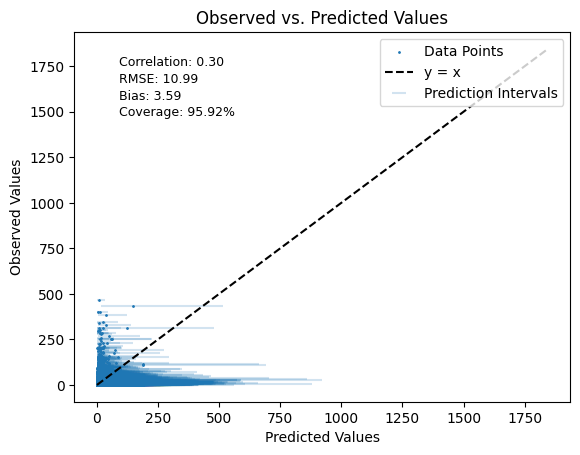

In [361]:
# # # Find overall min and max for xlim and ylim

# Flatten predicted_samples to make it 1-dimensional
predicted_counts_flat = predicted_counts.flatten()

# Concatenate the flattened predicted_samples with y
combined_array = np.concatenate([predicted_counts_flat, y_cleaned])

# calculate min and max
min_val = combined_array.min()
max_val = combined_array.max()

# Plotting
scatter = plt.scatter(monte_carlo_medians, y_cleaned, s=1, alpha=1, label='Data Points')
errorbar = plt.errorbar(monte_carlo_medians, y_cleaned, xerr=np.abs(prediction_intervals - monte_carlo_medians), fmt='none', alpha=0.2, label='Prediction Intervals')
y_equals_x = plt.plot([min_val, max_val], [min_val, max_val], 'k--', zorder=3, label='y = x')

# Add legend with metrics
legend_labels = [
    f'Correlation: {correlation:.2f}',
    f'RMSE: {rmse:.2f}',
    f'Bias: {bias:.2f}',
    f'Coverage: {coverage:.2%}'
]

# Add legend for plot elements
plt.legend(loc='upper right')

# Text annotations for metrics
text_x = min_val + (max_val - min_val) * 0.05  # Adjust these positions as necessary
text_y_start = max_val - (max_val - min_val) * 0.05  # Starting y position for text
line_height = (max_val - min_val) * 0.05  # Adjust line height as necessary

for i, label in enumerate(legend_labels):
    plt.text(text_x, text_y_start - i * line_height, label, fontsize=9)

plt.title('Observed vs. Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Observed Values')
plt.show()